In [3]:
#https://stackoverflow.com/questions/48828824/disable-warnings-in-jupyter-notebook
#imports
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup, NavigableString, Tag
import re
import time
import random
import sys
pd.set_option('display.max_colwidth', None)

from sklearn.metrics.pairwise import pairwise_distances, cosine_distances, cosine_similarity
from scipy import sparse
from matplotlib import pyplot as plt
import utils as ut

from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./data/video_games.csv')
print(ut.size_in_gb(df))

1.265136394 GB


In [3]:
df.dropna(inplace=True)

In [4]:
df.head() #preview

,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_date,full_review
0,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,5,0,0,1,2015-08-31,amazing joystick I especially love twist Used Elite Dangerous mac amazing joystick I especially love twist stick different movement binding well move normal way
1,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fateful Voyage,1,0,1,1,2015-08-31,One Star poor quality work advertised
2,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation 4 and PlayStation 3,3,0,0,1,2015-08-31,good could bettee nice tend slip away stick intense hard pressed gaming session
3,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super Smash Bros Series),4,0,0,1,2015-08-31,Great flawed Great amiibo great collecting Quality material desired since perfect
4,17521011,R2F0POU5K6F73F,B008XHCLFO,24234603,Protection for your 3DS XL,5,0,0,1,2015-08-31,A Must I 2012 2013 XL durable comfortable really cool looking


I'd like to see if I can isolate the most common words in an individual item's review text. The review text was already tokenized, lemmatized, and had stop words removed during the initial read-in/cleaning process that I created so the text should be ripe for analysis.

In [5]:
len(df['product_title'].unique()) #number of unique products represented in data

15938

In [6]:
prod_list = list(df['product_title'].unique())

In [7]:
prod_list[0]

'Thrustmaster T-Flight Hotas X Flight Stick'

In [8]:
prod_list[0].split(' ')

['Thrustmaster', 'T-Flight', 'Hotas', 'X', 'Flight', 'Stick']

In [9]:
sing_prod_df = df[df['product_title']==prod_list[0]]

In [10]:
list(sing_prod_df['full_review'])[0]

'amazing joystick I especially love twist Used Elite Dangerous mac amazing joystick I especially love twist stick different movement binding well move normal way'

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
#swords = ['the', 'it', 'wa', 'br', 'use', 'game', 'like', 'one'] #custom stop word list
#cvec = CountVectorizer(stop_words=swords)

def frequency_finder(dataframe, product): #finds most common words in revie for given product
    revs_df = dataframe[dataframe['product_title']==product] #make dataframe for that single product
    prod_text = list(revs_df['full_review']) #make a list of review text
    swords = ['the', 'it', 'wa', 'br', 'use', 'game', 'like', 'one', 'would', 'play', 'one',
             'two', 'three', 'four', 'five', 'stars', 'get', 'this', 'they', 'good', 'great',
             'best', 'time'] #custom stop word list
    for word in product.split(' '): #split title into list on spaces
        # add words from title to stop words list - remove common punctuation characters in titles
        swords.append(word.replace('(', '').replace(')', '').replace('-','').lower())   
    #print(swords) #preview stop word list
    cvec = CountVectorizer(stop_words=swords) #feed custom stop word list into cvec
    cvec_text = cvec.fit_transform(prod_text) #pass posts through count vectorizer
    text_df = pd.DataFrame(cvec_text.todense(), columns=cvec.get_feature_names()) #make df showing word frequency
    #return text_df #return dataframe of values 
    return ', '.join(dict(text_df.sum().sort_values(ascending=False).head(5)).keys()) #return top 5 words as string

In [12]:
frequency_finder(df, prod_list[0]) #test

'joystick, throttle, button, work, control'

In [13]:
#df['top_5_rev_words'] = df['product_title'].map(lambda x: frequency_finder(df, x)) #create new column in df
#ran for WAY too long

Okay - that's a good snapshot of the 5 most common words for a given product. I can generalize that function and use it across all products if I decide I want to add it to my returned search values.

I'd also like to see other NLP trends like what words are common when products are grouped by average star rating - or I could group products by average star rating and compare text that way.

In [12]:
for n in range(1,6): #how many reviews are there for each star possibility?
    print()
    print(f'Star Rating: {n}')
    print(len(df[df['star_rating']==n]))


Star Rating: 1
171966

Star Rating: 2
86201

Star Rating: 3
140101

Star Rating: 4
293505

Star Rating: 5
956316


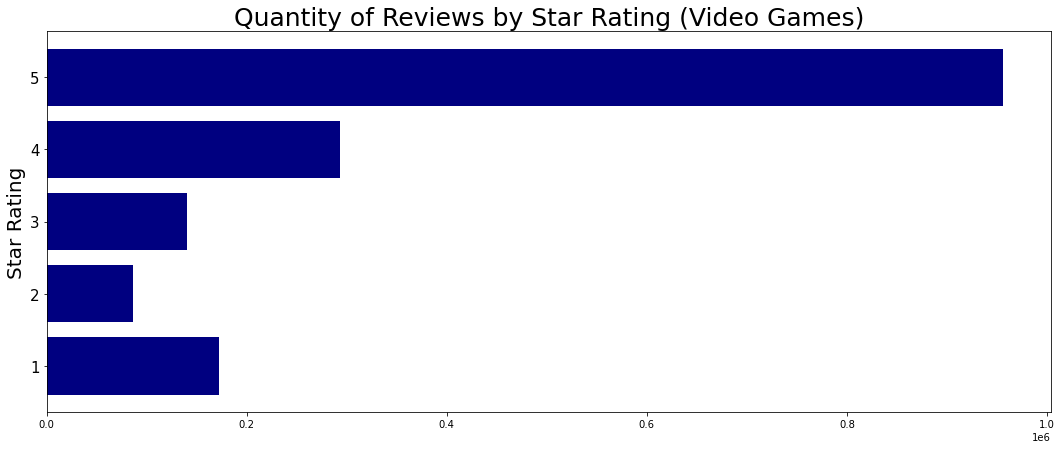

In [19]:
star_counts = dict(df.groupby('star_rating')['review_id'].count())
X = []
Y = []
for x, y in star_counts.items():
    X.append(x)
    Y.append(y)
plt.figure(figsize=(18,7))
plt.ylabel('Star Rating', size=20)
plt.yticks(size=15)
plt.title('Quantity of Reviews by Star Rating (Video Games)', size=25)
plt.barh(X,Y, color='navy');
#plt.savefig('./images/vg_q_stars.png', dpi=200, bbox_fit='tight');

In [17]:
#group by review star rating (1-5)

def frequency_finder_stars(dataframe, rating): #finds most common words in revie for given product
    revs_df = dataframe[dataframe['star_rating']==rating] #make dataframe for that single product
    prod_text = list(revs_df['full_review']) #make a list of review text
    #print(prod_text[:5])
    swords = ['the', 'it', 'wa', 'br', 'use', 'game', 'like', 'one', 'would', 'play', 'one',
             'two', 'three', 'four', 'five', 'stars', 'this', 'get', 'even', 'work',
             'really', 'time', 'ha', 'much', 'good', 'great', 'fun', 'well', 'thing',
             'first', 'also', 'make', 'way', 'you', 'character', 'better', 'still', 'if',
             'playing'] #custom stop word list
    #for word in product.split(' '):
        #swords.append(word.replace('(', ''). replace(')', '').lower())   # add words from title to stop words list
    #print(swords) #preview stop word list
    cvec = CountVectorizer(stop_words=swords,
                           ngram_range=(1,2), #search for words in range (#,#)
                           max_df = .4, #word can't appear more than given% of the time
                           min_df = .01,  # or less than min # times
                           max_features=5_000) #max # words
    cvec_text = cvec.fit_transform(prod_text) #pass posts through count vectorizer
    text_df = pd.DataFrame(cvec_text.todense(), columns=cvec.get_feature_names()) #make df showing word frequency

    plt.figure(figsize=(18,7))
    text_df.sum().sort_values(ascending=False).head(5).plot.barh(
    fontsize = '20',
    color='chartreuse'); #make bar chart of most frequent 10 words   
    plt.title(f'Most Frequent Words in {rating} Star Reviews', size=25)
    plt.savefig(f'./images/vg_{rating}star.png', dpi=200, bbox_fit='tight')
    return plt.show() #return plot (do not save df for sake of memory) 

In [15]:
#frequency_finder_stars(df, 1)

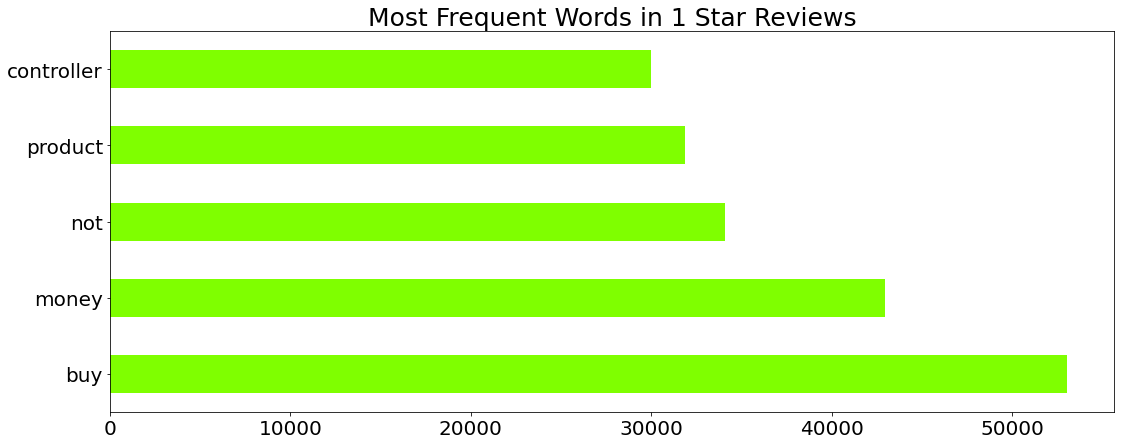

<Figure size 432x288 with 0 Axes>

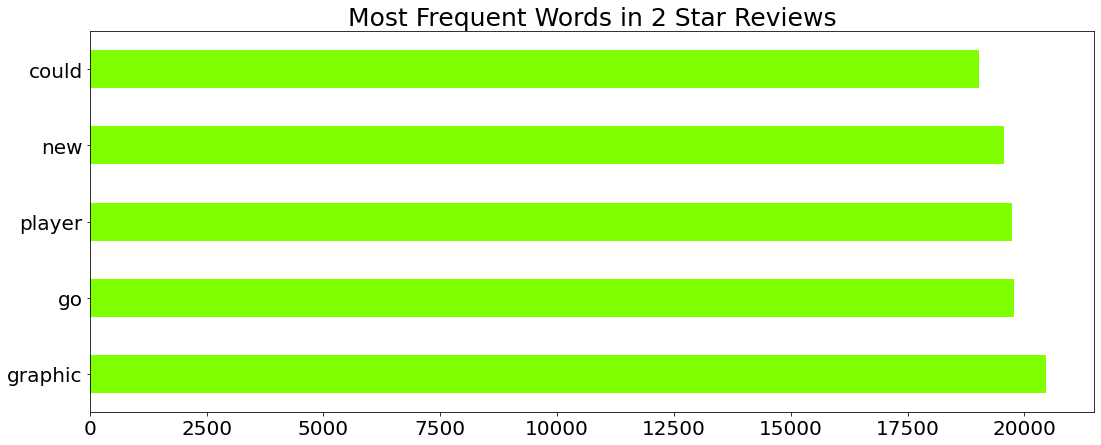

<Figure size 432x288 with 0 Axes>

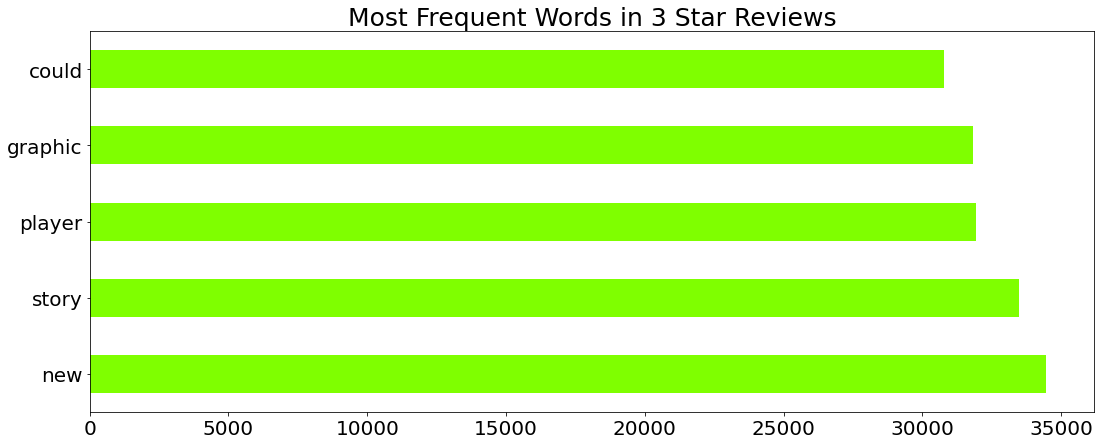

<Figure size 432x288 with 0 Axes>

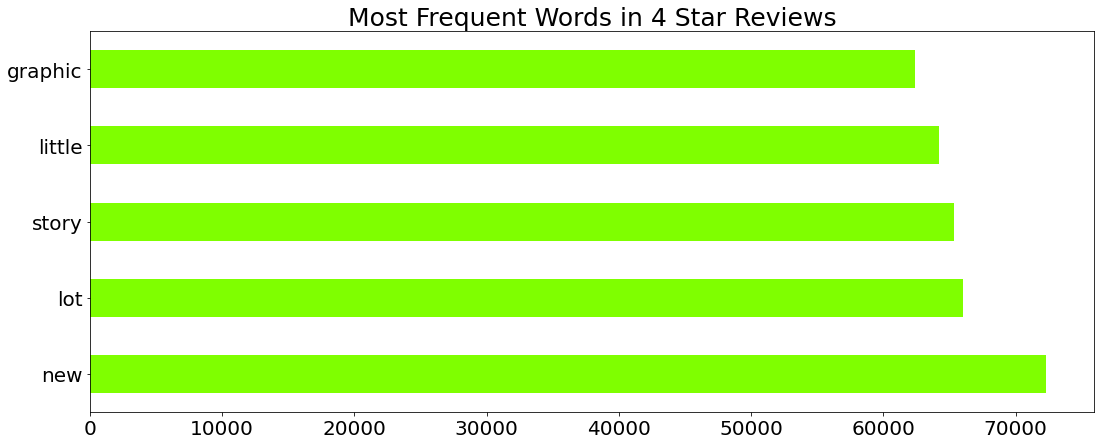

<Figure size 432x288 with 0 Axes>

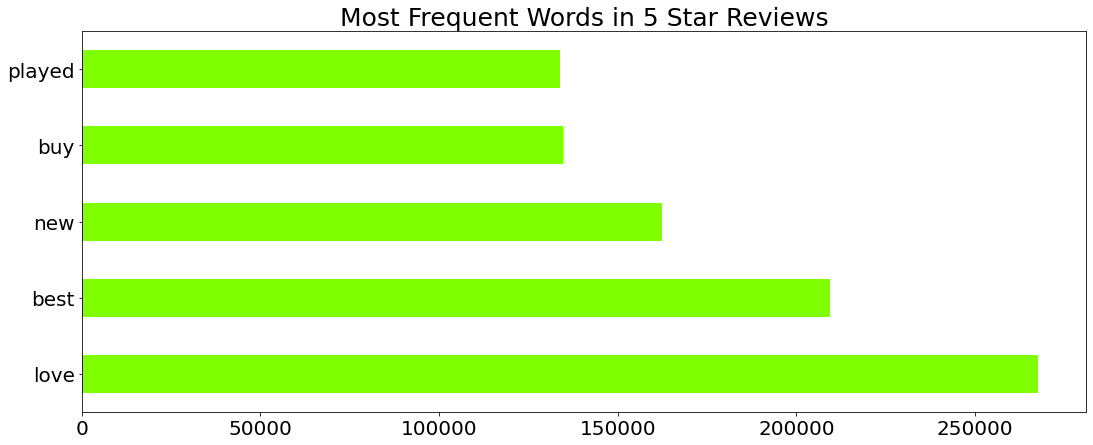

<Figure size 432x288 with 0 Axes>

In [16]:
for n in range(1,6): #numbers 1-5
    frequency_finder_stars(df, n)
    #plt.savefig(f'./images/vg_{n}star.png', dpi=200, bbox_fit='tight')

Okay - those metrics + the dictionary will be helpful for the video game section of my summary / web app. Time to create a function consolidating everything I did to this point so I can run books and movies through it.

In [21]:
def frequency_finder(dataframe, product): #finds most common words in revie for given product
    revs_df = dataframe[dataframe['product_title']==product] #make dataframe for that single product
    prod_text = list(revs_df['full_review']) #make a list of review text
    swords = ['the', 'it', 'wa', 'br', 'use', 'like', 'one', 'would', 'one',
             'two', 'three', 'four', 'five', 'stars', 'get', 'this', 'they', 'good', 'great',
             'best', 'ha', 'book', 'read', 'quot', 'story'] #custom stop word list
    for word in product.split(' '): #split title into list on spaces
        # add words from title to stop words list - remove common punctuation characters in titles
        swords.append(word.replace('(', '').replace(')', '').replace('-','').lower())   
    #print(swords) #preview stop word list
    cvec = CountVectorizer(stop_words=swords) #feed custom stop word list into cvec
    cvec_text = cvec.fit_transform(prod_text) #pass posts through count vectorizer
    text_df = pd.DataFrame(cvec_text.todense(), columns=cvec.get_feature_names()) #make df showing word frequency
    return ', '.join(dict(text_df.sum().sort_values(ascending=False).head(5)).keys()) #return top 5 words as string

In [12]:
df = pd.read_csv('./data/books.csv', usecols=['product_title', 'full_review'])

In [17]:
df.dropna(inplace=True) #drop 2 empty review texts
print(df.shape)
df.head() #preview

(1489352, 2)


,product_title,full_review
0,Sisterhood of the Traveling Pants (Book 1),book wa great learning novel boook wa great one could learn teach imponrtance family value also deal basic issue teen kid even deal book 4 best friend first time life spending summer apart one day one girl room find pair pant tucked away closet four try realize really something special pant seeming 4 girl differnt shape size somehow pant fit realize pant start something special immediatley following decided make certian rule abut pant must write best thing u wearing pant summer right leg also silly thing never pick yuor nose wearing pant book follows girl throuh summer differnt place world different obstacle life take really teach alot going around imporntantly yuorself would give book 4 star would reccommend anyone seems slihgtest bit interested
1,The Bad Girl's Guide to Getting What You Want,Fun Fluff If looking something stimulate brain However looking good laugh enjoy The Bad Girl Guide It funny light definitely good way pas little bit time
2,The Catcher in the Rye,Interesting fun My complaint book wa bit repetative Holden vocabulary consists 4 word sonuvabitch goddamn lousy phony It wa still quite humorous actual story wa interesting br br It wa easy read relate pick looking fun read Some people complain lack plot understand book need read deeper It actually lot annoying kid list complaint life br br The story Holden Caulfield coming age realizing growing process stopped He lousy childhood put want save child going though thing experienced life He telling story mental institution wa placed returning home fourth Prep school kicked He flash back event leading arrival home tell story 3 day
3,Bait and Switch: The (Futile) Pursuit of the American Dream,I viewed opposite Publisher Weekly This book chilling depressing indeed though well written sprinkled frequent humor I wa sort surprised however comment Publisher Weekly said PW suspect many buyer disappointed Ehrenreich deliver promised story never managed get employed midlevel corporate world wanted analyze I never viewed promised story first place To primary point book wa describe wa like actually try ENTER world first place rather describing life wa like got In fact I actually thought lucked sense bizarre surreal experience make entertaining thought provoking reading mind HAD obtained job right away would taken away whole raison etre book It would completely different book merely described presumably boring mid level corporate job probably would day day Thus least purpose writing book I think wa lucky thing worked way As reader criticized taking job offered AFLAC Mary Kay I thought comment bizarre I agree Ms Ehrenreich point job employer offer salary benefit office help essentially take risk whatsoever hardly considered job traditional sense wa seeking In event really pretty scary depressing book one I recommend
4,Hour Game (King & Maxwell),A good read If enjoy well told yarn intrigue told skillfully able predict ending really good done


In [14]:
prod_df = pd.read_pickle('./compressed/books_look_c.pkl')
prod_list = list(prod_df['product_title'])
len(prod_list) #preview

46575

In [22]:
#create dictionary of keywords matched w/products
books_rev_words = {x : frequency_finder(df,x) for x in prod_list}

In [24]:
books_rev_words;

In [25]:
#now, for movies
df = pd.read_csv('./data/movie_dvd.csv', usecols=['product_title', 'full_review'])

In [26]:
df.dropna(inplace=True) #drop empty review texts
print(df.shape)
df.head() #preview

(4405369, 2)


,product_title,full_review
0,"Yoga for Movement Disorders DVD: Rebuilding Strength, Balance, and Flexibility for Parkinson's Disease and Dystonia",This wa gift aunt ha Parkinson This wa gift aunt ha Parkinson While I previewed I also gotten complaint My prior experience yoga tell doctor ordered
1,Something Borrowed,Five Stars Teats heart
2,Les Miserables (2012) [Blu-ray],Great movie Great movie
3,Alien Anthology and Prometheus Bundle [Blu-ray],Amazing My husband wa excited receive gift Great picture quality great value
4,Sex and the City 2,Five Stars Love series


In [27]:
prod_df = pd.read_pickle('./compressed/movies_look_c.pkl')
prod_list = list(prod_df['product_title'])
len(prod_list) #preview

72385

In [33]:
# will add stop words for subject matter as needed

def frequency_finder(dataframe, product): #finds most common words in revie for given product
    revs_df = dataframe[dataframe['product_title']==product] #make dataframe for that single product
    prod_text = list(revs_df['full_review']) #make a list of review text
    swords = ['the', 'it', 'wa', 'br', 'use', 'like', 'one', 'would', 'one',
             'two', 'three', 'four', 'five', 'stars', 'get', 'this', 'they', 'good', 'great',
             'best', 'ha', 'dvd', 'blu', 'movie', 'ray','film','quot'] #custom stop word list
    for word in product.split(' '): #split title into list on spaces
        # add words from title to stop words list - remove common punctuation characters in titles
        swords.append(word.replace('(', '').replace(')', '').replace('-','').lower())   
    #print(swords) #preview stop word list
    cvec = CountVectorizer(stop_words=swords) #feed custom stop word list into cvec
    cvec_text = cvec.fit_transform(prod_text) #pass posts through count vectorizer
    text_df = pd.DataFrame(cvec_text.todense(), columns=cvec.get_feature_names()) #make df showing word frequency
    return ', '.join(dict(text_df.sum().sort_values(ascending=False).head(5)).keys()) #return top 5 words as string

In [34]:
movies_rev_words = {x : frequency_finder(df,x) for x in prod_list}

In [36]:
movies_rev_words;

In [37]:
import pickle #saving dictionary for future use

In [38]:
with open('./compressed/books_text_dict.pkl', 'wb') as f:
    pickle.dump(books_rev_words, f)
    
with open('./compressed/movies_text_dict.pkl', 'wb') as f:
    pickle.dump(movies_rev_words, f)

Great! Time to get these uploaded to github and try pulling in the data for my recommender!